# Modelos
### XGBoost - Decision Tree - Random Forest - Logistic Regression - LightGBM

Levanta data_df.csv generado por EDA.

In [1]:
# tuve que reinstalar con conda uninstall scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import make_scorer

from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
# Suppressing warnings because of skopt and other algorithms verbosity
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Lectura del dataset generado en el proceso de EDA.
df = pd.read_csv('data_df.csv')

# df=df.drop(['Unnamed: 0'], axis=1) # Elimino la columna que me generó el pd.write_csv() del EDA.

In [4]:
# df.columns

In [5]:
# df.info()

In [6]:
# Feature selection
# df con las variables independientes a incluir en el modelo. Surgen del EDA realizado.
# dfModel =df.drop('fraude', axis=1)
# 
dfModel=df[['endoso', 'ase_antig_an', 'ase_cp', 'ase_codnac', 'idprod', 'pro_antig_an', 
            'marca', 'modelo', 'anio', 'uso', 'codcober', 'cob_ef']]

In [7]:
# Es la variable dependiente/objetivo/target 'fraude'
dfTarget=df['fraude']

In [8]:
# Divido en training y testing. 
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45)

In [9]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12140
            0.0369%

Testing 0: 140811
Testing 1: 5096
           0.0362%


In [10]:
# Divido en training y testing. Utilizo 'stratify' para mantener la proporción de positivos y negativos en train y test.
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45, stratify=dfTarget)

In [11]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12065
            0.0367%

Testing 0: 140811
Testing 1: 5171
           0.0367%


###  ---Algoritmo XGBoost---

In [12]:
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier  ## Categorical target variable
# from xgboost import XGBRegressor ## Continuous target variable

### XGBoost - Sin Feature Engineering - Parámetros Default.

In [13]:
clf_xgb = xgb.XGBClassifier(eval_metric='auc')

In [14]:
# Fitting model
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

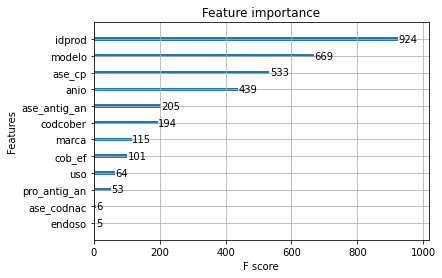

In [15]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb, ax=plt.gca())
y_pred  = clf_xgb.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    135640
           1       0.56      0.51      0.53      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.75      0.76    140811
weighted avg       0.97      0.97      0.97    140811



In [17]:
confusion_matrix(y_test, y_pred)

array([[133610,   2030],
       [  2544,   2627]], dtype=int64)

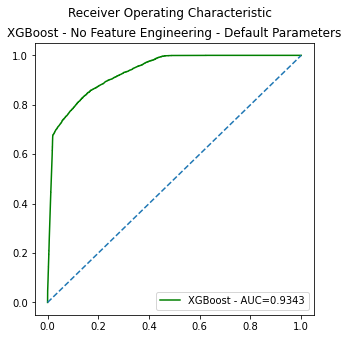

In [18]:
y_pred_proba = clf_xgb.predict_proba(X_test)[::,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('XGBoost - No Feature Engineering - Default Parameters')
plt.plot(fpr_xgb,tpr_xgb,color="green",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### XGBoost - Sin Feature Engineering - Optimización Bayesiana.

In [19]:
def xgb_classifier(n_estimators, max_depth, reg_alpha, reg_lambda, min_child_weight, num_boost_round, gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.02,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    
    train_data = xgb.DMatrix(X_train, y_train)
    
    cv_result = xgb.cv(params, train_data, 1000, early_stopping_rounds=100, stratified=True, nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [20]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
xgbBO = BayesianOptimization(xgb_classifier, {  'n_estimators': (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (100, 1000),
                                                "gamma": (0, 10)
                                                })

In [21]:
##### xgbBO.maximize(n_iter=20, init_points=2) # n_iter=35

In [22]:
##### xgbBO.max

In [23]:
# clf_xgb=XGBClassifier(use_label_encoder=False, 
#                       colsample_bytree = 0.5, 
#                       learning_rate = 0.2,
#                       gamma =  7.913757545198536,
#                       max_depth = 7,
#                       min_child_weight = 1.9202611553414282,
#                       alpha = 10, 
#                       n_estimators = 45,
#                       reg_alpha =   0.07711402098002348,
#                       reg_lambda = 0.0433274269286166,
#                       eval_metric='auc')

# n_estimators = 45

clf_xgb_BO=XGBClassifier(use_label_encoder=False, 
                      colsample_bytree = 0.5, 
                      learning_rate = 0.2,
                      gamma =  8.141210926403971,
                      max_depth = 10,
                      min_child_weight = 6.779723064345376,
                      alpha = 10, 
                      n_estimators = 50,
                      reg_alpha = 0.08672170218151724,
                      reg_lambda = 0.048019737256687234,
                      eval_metric='auc')

In [24]:
# Fitting model
clf_xgb_BO.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=8.141210926403971, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=10, min_child_weight=6.779723064345376, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.08672170218151724, reg_lambda=0.048019737256687234,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

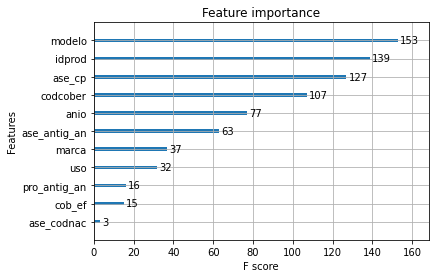

In [25]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb_BO, ax=plt.gca())
y_pred  = clf_xgb_BO.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.56      0.59      0.58      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.79      0.78    140811
weighted avg       0.97      0.97      0.97    140811



In [27]:
confusion_matrix(y_test, y_pred)

array([[133215,   2425],
       [  2098,   3073]], dtype=int64)

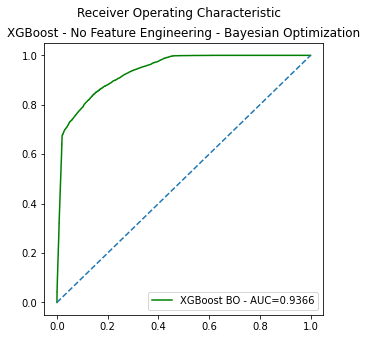

In [28]:
y_pred_proba = clf_xgb_BO.predict_proba(X_test)[::,1]
fpr_xgb_BO, tpr_xgb_BO, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb_BO = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('XGBoost - No Feature Engineering - Bayesian Optimization')
plt.plot(fpr_xgb_BO,tpr_xgb_BO,color="green",label="XGBoost BO - AUC=%.4f" % auc_xgb_BO)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Decision Tree---

In [29]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

In [30]:
# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier(criterion='entropy',
                                min_samples_split=20,
                                min_samples_leaf=5,
                                max_depth = 20,
                                class_weight={1:27})

# Parámetros:
# -----------
# criterion --> podría ser gini también.
# class_weight --> surge de dividir cantidad de 0 sobre cantidad de 1. Con esto se compensa el desbalance.
# min_samples_split --> se refiere a la cantidad mínima de muestras que debe tener un nodo para poder subdividir.
# min_samples_leaf --> cantidad mínima que puede tener una hoja final. Si tuviera menos, no se formaría esa hoja 
#                      y subiría un nivel, su antecesor.

# Train Decision Tree Classifer
clf_dt = clf_dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf_dt.predict(X_test)

In [31]:
# Visualizing Decision Trees
# !pip install StringIO

# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(clf_dt, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = feature_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('decision_tree.png')
# Image(graph.create_png())

In [32]:
# view accuracy
accuracy=accuracy_score(y_pred, y_test)
print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8799


In [33]:
y_pred_train = clf_dt.predict(X_train)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    135640
           1       0.20      0.79      0.32      5171

    accuracy                           0.88    140811
   macro avg       0.60      0.84      0.63    140811
weighted avg       0.96      0.88      0.91    140811



In [35]:
confusion_matrix(y_test, y_pred)

array([[119836,  15804],
       [  1103,   4068]], dtype=int64)

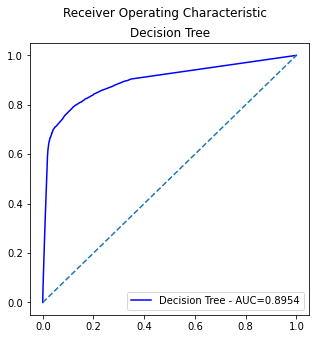

In [36]:
y_pred_proba = clf_dt.predict_proba(X_test)[::,1]
fpr_dt, tpr_dt, _ = roc_curve(y_test,  y_pred_proba)
auc_dt = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('Decision Tree')
plt.plot(fpr_dt,tpr_dt,color="blue",label="Decision Tree - AUC=%.4f" % auc_dt)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Random Forest---

In [37]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
# Create a Gaussian Classifier
clf_rf=RandomForestClassifier(n_estimators=100, class_weight={0:1,1:27})
# Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_train,y_train)
y_pred=clf_rf.predict(X_test)

In [38]:
# feature_imp = pd.Series(clf.feature_importances_,index=df.feature_names).sort_values(ascending=False)
feature_imp = pd.Series(clf_rf.feature_importances_).sort_values(ascending=False)
feature_imp

10    0.235444
4     0.162838
9     0.152776
8     0.133733
7     0.107989
1     0.092973
2     0.047641
6     0.047293
11    0.009747
5     0.009301
3     0.000222
0     0.000045
dtype: float64

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    135640
           1       0.51      0.39      0.44      5171

    accuracy                           0.96    140811
   macro avg       0.74      0.69      0.71    140811
weighted avg       0.96      0.96      0.96    140811



In [40]:
confusion_matrix(y_test, y_pred)

array([[133698,   1942],
       [  3171,   2000]], dtype=int64)

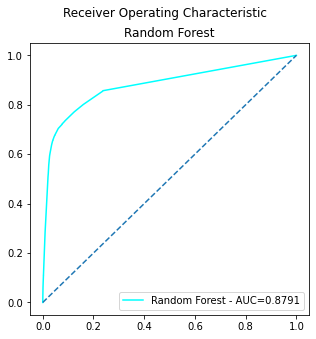

In [41]:
y_pred_proba = clf_rf.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test,  y_pred_proba)
auc_rf = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('Random Forest')
plt.plot(fpr_rf,tpr_rf,color="cyan",label="Random Forest - AUC=%.4f" % auc_rf)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Logistic Regression---

In [42]:
# import the class
from sklearn.linear_model import LogisticRegression

In [43]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [44]:
# !pip install imblearn
# from sklearn.metrics import pairwise
# from imblearn.under_sampling import NearMiss # us = NearMiss(ratio=0.5, n_neighbors=3, version=2, random_state=1)
# us = NearMiss(n_neighbors=3, version=2)
# X_train_res, y_train_res = us.fit_resample(X_train, y_train)
# Estrategia: Subsampling en la clase mayoritaria
# Da memory error
# MemoryError: Unable to allocate 28.5 GiB for an array with shape (316494, 12065) and data type float64
# Probar en VM en la nube

In [45]:
os =  RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

In [46]:
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 316494, 1: 12065})
Distribution labels after resampling Counter({0: 316494, 1: 316494})


In [47]:
clf_lr_os=LogisticRegression(solver='liblinear', random_state=0)
# fit the model with data oversampled
clf_lr_os.fit(X_train_res,y_train_res)
y_pred=clf_lr_os.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93    135640
           1       0.18      0.74      0.29      5171

    accuracy                           0.87    140811
   macro avg       0.59      0.81      0.61    140811
weighted avg       0.96      0.87      0.90    140811



In [49]:
confusion_matrix(y_test, y_pred)

array([[118558,  17082],
       [  1326,   3845]], dtype=int64)

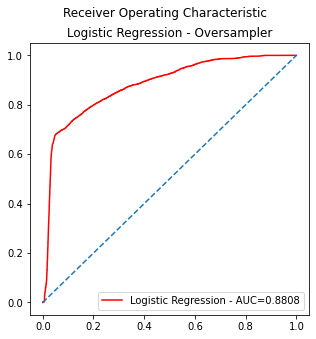

In [50]:
y_pred_proba = clf_lr_os.predict_proba(X_test)[::,1]
fpr_lr_os, tpr_lr_os, _ = roc_curve(y_test,  y_pred_proba)
auc_lr_os = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('Logistic Regression - Oversampler')
plt.plot(fpr_lr_os,tpr_lr_os,color="red",label="Logistic Regression - AUC=%.4f" % auc_lr_os)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

In [51]:
clf_lr=LogisticRegression(solver='liblinear', random_state=0, class_weight="balanced")
# fit the model with data
clf_lr.fit(X_train,y_train)
y_pred=clf_lr.predict(X_test)

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    135640
           1       0.19      0.74      0.30      5171

    accuracy                           0.87    140811
   macro avg       0.59      0.81      0.61    140811
weighted avg       0.96      0.87      0.91    140811



In [53]:
confusion_matrix(y_test, y_pred)

array([[118745,  16895],
       [  1324,   3847]], dtype=int64)

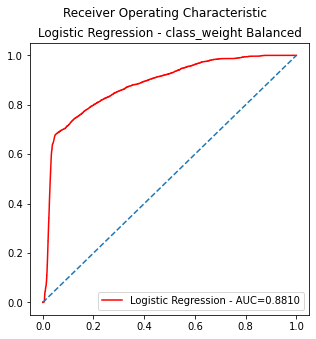

In [54]:
y_pred_proba = clf_lr.predict_proba(X_test)[::,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test,  y_pred_proba)
auc_lr = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('Logistic Regression - class_weight Balanced')
plt.plot(fpr_lr,tpr_lr,color="red",label="Logistic Regression - AUC=%.4f" % auc_lr)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---LightGBM---

In [55]:
import lightgbm as lgb

### LightGBM - Sin Feature Engineering - Parámetros Default.

In [56]:
# build the lightgbm model
clf_lgbm = lgb.LGBMClassifier()
clf_lgbm.fit(X_train, y_train)

# predict the results
y_pred=clf_lgbm.predict(X_test)

In [57]:
y_pred_train = clf_lgbm.predict(X_train)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.56      0.61      0.58      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.79      0.78    140811
weighted avg       0.97      0.97      0.97    140811



In [59]:
confusion_matrix(y_test, y_pred)

array([[133144,   2496],
       [  2032,   3139]], dtype=int64)

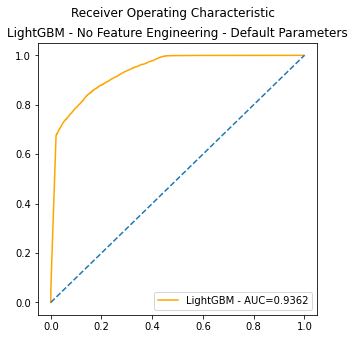

In [60]:
y_pred_proba = clf_lgbm.predict_proba(X_test)[::,1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test,  y_pred_proba)
auc_lgbm = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('LightGBM - No Feature Engineering - Default Parameters')
plt.plot(fpr_lgbm,tpr_lgbm,color="orange",label="LightGBM - AUC=%.4f" % auc_lgbm)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### LightGBM - Sin Feature Engineering - Optimización Bayesiana.

In [61]:
# !pip install scikit-optimize

In [62]:
# Importing core libraries
from time import time
import pprint

# Model selection
from sklearn.model_selection import StratifiedKFold

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

In [63]:
# Reporting util for different optimizers
def report_perf(optimizer, X_train, y_train, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X_train, y_train, callback=callbacks)
    else:
        optimizer.fit(X_train, y_train)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [64]:
# Converting average precision score into a scorer suitable for model selection
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

In [65]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [66]:
clf_lgbm_BO = lgb.LGBMClassifier(boosting_type='gbdt', metric='auc', objective='binary', n_jobs=1, verbose=-1, random_state=0)

In [67]:
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 500),                    # 30, 5000 - Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'max_bin': Integer(100, 1000),                       # Max number of bins that feature values will be bucketed
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight (hessian) needed in a child (leaf)
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
    'scale_pos_weight': Real(1.0, 500.0, 'uniform'),     # Weighting of the minority class (Only for binary classification)
        }

In [68]:
opt = BayesSearchCV(estimator=clf_lgbm_BO,                                    
                    search_spaces=search_spaces,                      
                    scoring=roc_auc,                                  
                    cv=skf,                                           
                    n_iter=25,                                        # 3000 - max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [69]:
##### overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
##### time_limit_control = DeadlineStopper(total_time=60 * 25)     # We impose a time limit (45 minutes)
##### best_params = report_perf(opt, X_train, y_train,'LightGBM', callbacks=[overdone_control, time_limit_control])

In [70]:
# build the lightgbm model
clf_lgbm_BO = lgb.LGBMClassifier(colsample_bytree=0.9716227061653782,
             learning_rate=0.01940795180198195,
             max_bin=1000,
             max_depth=6,
             min_child_samples=256,
             min_child_weight=10,
             n_estimators=500,
             num_leaves=475,
             reg_alpha=1e-09,
             reg_lambda=8.668516082240835e-07,
             scale_pos_weight=1.0,
             subsample=0.9582204225616259,
             subsample_freq=10)
clf_lgbm_BO.fit(X_train, y_train)

# predict the results
y_pred=clf_lgbm_BO.predict(X_test)

In [71]:
y_pred_train = clf_lgbm_BO.predict(X_train)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.56      0.59      0.58      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.79      0.78    140811
weighted avg       0.97      0.97      0.97    140811



In [73]:
confusion_matrix(y_test, y_pred)

array([[133274,   2366],
       [  2118,   3053]], dtype=int64)

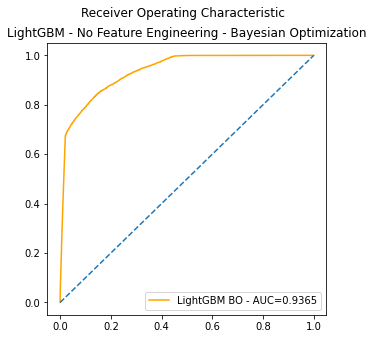

In [74]:
y_pred_proba = clf_lgbm_BO.predict_proba(X_test)[::,1]
fpr_lgbm_BO, tpr_lgbm_BO, _ = roc_curve(y_test,  y_pred_proba)
auc_lgbm_BO = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('LightGBM - No Feature Engineering - Bayesian Optimization')
plt.plot(fpr_lgbm_BO,tpr_lgbm_BO,color="orange",label="LightGBM BO - AUC=%.4f" % auc_lgbm_BO)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ROC Curve y AUC - Todos los modelos hasta ahora

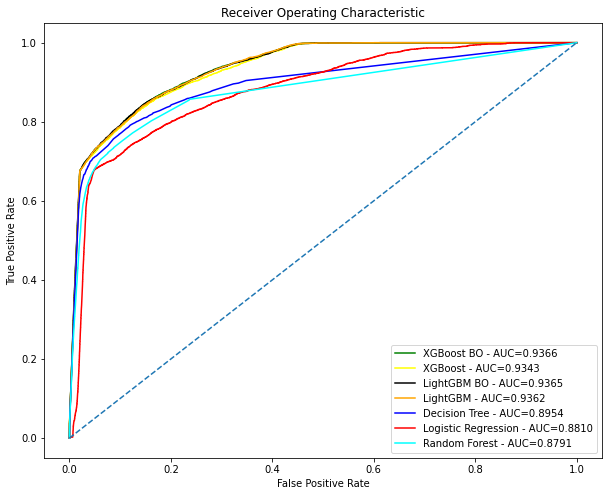

In [75]:
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb_BO,tpr_xgb_BO,color="green",label="XGBoost BO - AUC=%.4f" % auc_xgb_BO)
plt.plot(fpr_xgb,tpr_xgb,color="yellow",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot(fpr_lgbm_BO,tpr_lgbm_BO,color="black",label="LightGBM BO - AUC=%.4f" % auc_lgbm_BO)
plt.plot(fpr_lgbm,tpr_lgbm,color="orange",label="LightGBM - AUC=%.4f" % auc_lgbm)
plt.plot(fpr_dt,tpr_dt,color="blue",label="Decision Tree - AUC=%.4f" % auc_dt)
plt.plot(fpr_lr,tpr_lr,color="red",label="Logistic Regression - AUC=%.4f" % auc_lr)
plt.plot(fpr_rf,tpr_rf,color="cyan",label="Random Forest - AUC=%.4f" % auc_rf)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('plt_ROC_Curve_Modelos.jpg')
plt.show()

In [76]:
from sklearn.model_selection import cross_val_score

# Applying k-Fold Cross Validation
roc_auc_score_xgb_BO =cross_val_score(estimator=clf_xgb_BO , X=X_train, y=y_train, cv=5, scoring='roc_auc')
roc_auc_score_dt     =cross_val_score(estimator=clf_dt     , X=X_train, y=y_train, cv=5, scoring='roc_auc')
roc_auc_score_rf     =cross_val_score(estimator=clf_rf     , X=X_train, y=y_train, cv=5, scoring='roc_auc')
roc_auc_score_lr     =cross_val_score(estimator=clf_lr     , X=X_train, y=y_train, cv=5, scoring='roc_auc')
roc_auc_score_lgbm_BO=cross_val_score(estimator=clf_lgbm_BO, X=X_train, y=y_train, cv=5, scoring='roc_auc')

In [77]:
print("XGBoost BO - 5-fold cross validation - AUC mean         : %.4f" % roc_auc_score_xgb_BO.mean())
print("Decision Tree - 5-fold cross validation - AUC mean      : %.4f" % roc_auc_score_dt.mean())
print("Random Forest - 5-fold cross validation - AUC mean      : %.4f" % roc_auc_score_rf.mean())
print("Logistic Regression - 5-fold cross validation - AUC mean: %.4f" % roc_auc_score_lr.mean())
print("LightGBM BO - 5-fold cross validation - AUC mean        : %.4f" % roc_auc_score_lgbm_BO.mean())

XGBoost BO - 5-fold cross validation - AUC mean         : 0.9370
Decision Tree - 5-fold cross validation - AUC mean      : 0.8850
Random Forest - 5-fold cross validation - AUC mean      : 0.8739
Logistic Regression - 5-fold cross validation - AUC mean: 0.8782
LightGBM BO - 5-fold cross validation - AUC mean        : 0.9370


In [78]:
df_roc_auc_score_xgb_BO =pd.DataFrame(roc_auc_score_xgb_BO)
df_roc_auc_score_dt     =pd.DataFrame(roc_auc_score_dt)
df_roc_auc_score_rf     =pd.DataFrame(roc_auc_score_rf)
df_roc_auc_score_lr     =pd.DataFrame(roc_auc_score_lr)
df_roc_auc_score_lgbm_BO=pd.DataFrame(roc_auc_score_lgbm_BO)

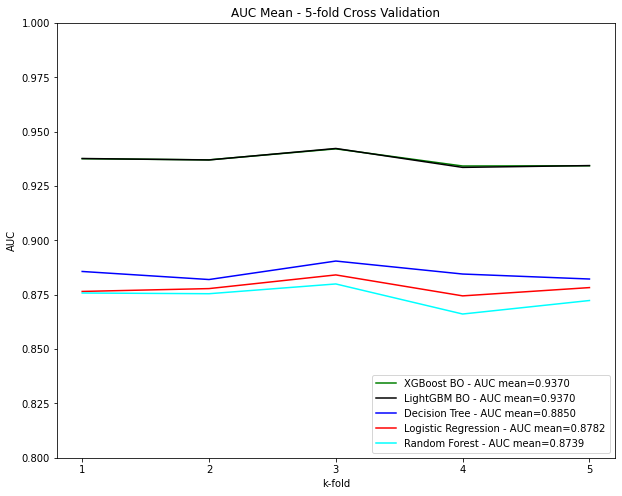

In [79]:
plt.figure(figsize=(10,8))
plt.title('AUC Mean - 5-fold Cross Validation')
plt.plot(df_roc_auc_score_xgb_BO,color="green",label="XGBoost BO - AUC mean=%.4f" % df_roc_auc_score_xgb_BO.mean())
plt.plot(df_roc_auc_score_lgbm_BO,color="black",label="LightGBM BO - AUC mean=%.4f" % df_roc_auc_score_lgbm_BO.mean())
plt.plot(df_roc_auc_score_dt,color="blue",label="Decision Tree - AUC mean=%.4f" % df_roc_auc_score_dt.mean())
plt.plot(df_roc_auc_score_lr,color="red",label="Logistic Regression - AUC mean=%.4f" % df_roc_auc_score_lr.mean())
plt.plot(df_roc_auc_score_rf,color="cyan",label="Random Forest - AUC mean=%.4f" % df_roc_auc_score_rf.mean())
plt.legend(loc=4)
plt.xlabel("k-fold")
plt.ylabel("AUC")
x_ticks=[0,1,2,3,4]
x_labels=[1,2,3,4,5]
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.ylim(0.8, 1)
plt.savefig('plt_cross_validation_5fold.jpg')
plt.show()

### En base al rendimiento demostrado, se elige ---XGBoost--- y ---LightGBM--- como los algoritmos a desarrollar. 

In [80]:
# comienzo nuevo proceso solo con XGBoost y LightGBM.

### Feature Engineering

In [81]:
# Anio Fecha Ultima Cobranza.
df['Fe_New1'] = pd.to_numeric(df['cob_fecuma'].astype(str).str.slice(0,4))

In [82]:
# Mes Fecha Ultima Cobranza.
df['Fe_New2'] = pd.to_numeric(df['cob_fecuma'].astype(str).str.slice(4,6))

In [83]:
# Anio Fecha Emisión de la Operación.
df['Fe_New3'] = pd.to_numeric(df['fecemi'].astype(str).str.slice(0,4))

In [84]:
# Mes Emisión de la Operación.
df['Fe_New4'] = pd.to_numeric(df['fecemi'].astype(str).str.slice(4,6))

In [85]:
# la diferencia entre el día de proceso y la última cobranza.
df['Fe_New5'] = (pd.Timestamp.now().normalize()-pd.to_datetime(df['cob_fecuma'], format='%Y%m%d')).dt.days

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469370 entries, 0 to 469369
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pol           469370 non-null  int64  
 1   endoso        469370 non-null  int64  
 2   item          469370 non-null  int64  
 3   fecemi        469370 non-null  int64  
 4   tipend        469370 non-null  object 
 5   idaseg        469370 non-null  int64  
 6   ase_antig_an  469370 non-null  int64  
 7   ase_cp        469370 non-null  int64  
 8   ase_codnac    469370 non-null  float64
 9   ase_nac       469370 non-null  object 
 10  idprod        469370 non-null  int64  
 11  pro_antig_an  469370 non-null  int64  
 12  tipveh        469370 non-null  int64  
 13  marca         469370 non-null  int64  
 14  modelo        469370 non-null  int64  
 15  anio          469370 non-null  int64  
 16  uso           469370 non-null  int64  
 17  uso_desc      469370 non-null  object 
 18  cobe

### Feature Selection

In [87]:
dfModel=df[['endoso', 'ase_antig_an', 'ase_cp', 'ase_codnac', 'idprod', 'pro_antig_an', 
            'marca', 'modelo', 'anio', 'uso', 'codcober', 'cob_ef', 
            'Fe_New1', 'Fe_New2', 'Fe_New3', 'Fe_New4', 'Fe_New5']]

In [88]:
# Es la variable dependiente/objetivo/target 'fraude'
dfTarget=df['fraude']

In [89]:
# Divido en training y testing. Utilizo 'stratify' para mantener la proporción de positivos y negativos en train y test.
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45, stratify=dfTarget)

In [90]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12065
            0.0367%

Testing 0: 140811
Testing 1: 5171
           0.0367%


### XGBoost FE default

In [91]:
clf_xgb_FE = xgb.XGBClassifier(eval_metric='auc')

In [92]:
# Fitting model
clf_xgb_FE.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

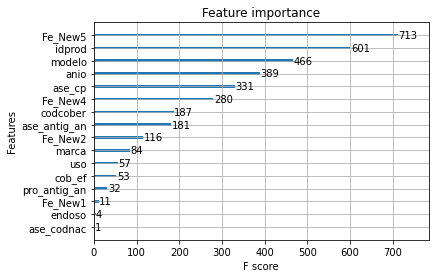

In [93]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb_FE, ax=plt.gca())
y_pred  = clf_xgb_FE.predict(X_test)

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135640
           1       0.97      0.65      0.78      5171

    accuracy                           0.99    140811
   macro avg       0.98      0.83      0.89    140811
weighted avg       0.99      0.99      0.99    140811



In [95]:
confusion_matrix(y_test, y_pred)

array([[135529,    111],
       [  1794,   3377]], dtype=int64)

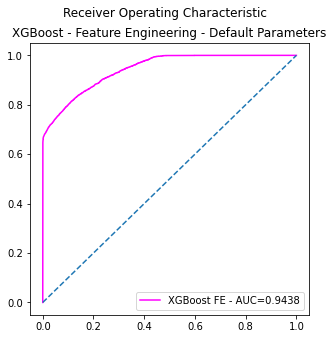

In [96]:
y_pred_proba = clf_xgb_FE.predict_proba(X_test)[::,1]
fpr_xgb_FE, tpr_xgb_FE, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb_FE = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('XGBoost - Feature Engineering - Default Parameters')
plt.plot(fpr_xgb_FE,tpr_xgb_FE,color="magenta",label="XGBoost FE - AUC=%.4f" % auc_xgb_FE)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### XGBoost FE BO

In [97]:
def xgb_classifier(n_estimators, max_depth, reg_alpha, reg_lambda, min_child_weight, num_boost_round, gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.02,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    
    train_data = xgb.DMatrix(X_train, y_train)
    
    cv_result = xgb.cv(params, train_data, 1000, early_stopping_rounds=100, stratified=True, nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [98]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
xgbBO_FE = BayesianOptimization(xgb_classifier, {  'n_estimators': (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (100, 1000),
                                                "gamma": (0, 10)
                                                })

In [99]:
##### xgbBO_FE.maximize(n_iter=20, init_points=2) # n_iter=35

In [100]:
##### xgbBO_FE.max

In [101]:
# clf_xgb_BO_FE=XGBClassifier(use_label_encoder=False, 
#                       colsample_bytree = 0.5, 
#                       learning_rate = 0.2,
#                       gamma =  7.913757545198536,
#                       max_depth = 7,
#                       min_child_weight = 1.9202611553414282,
#                       alpha = 10, 
#                       n_estimators = 45,
#                       reg_alpha =   0.07711402098002348,
#                       reg_lambda = 0.0433274269286166,
#                       eval_metric='auc')

# n_estimators = 45

clf_xgb_BO_FE=XGBClassifier(use_label_encoder=False, 
                      colsample_bytree = 0.5, 
                      learning_rate = 0.2,
                      gamma =  8.141210926403971,
                      max_depth = 10,
                      min_child_weight = 6.779723064345376,
                      alpha = 10, 
                      n_estimators = 50,
                      reg_alpha = 0.08672170218151724,
                      reg_lambda = 0.048019737256687234,
                      eval_metric='auc')

In [102]:
# Fitting model
clf_xgb_BO_FE.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=8.141210926403971, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=10, min_child_weight=6.779723064345376, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.08672170218151724, reg_lambda=0.048019737256687234,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

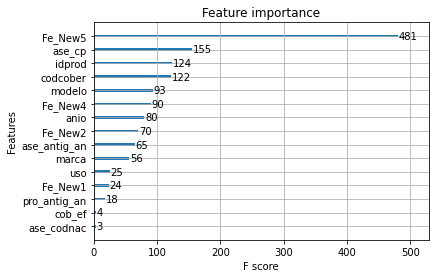

In [103]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb_BO_FE, ax=plt.gca())
y_pred  = clf_xgb_BO_FE.predict(X_test)

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135640
           1       0.96      0.65      0.78      5171

    accuracy                           0.99    140811
   macro avg       0.97      0.83      0.89    140811
weighted avg       0.99      0.99      0.98    140811



In [105]:
confusion_matrix(y_test, y_pred)

array([[135504,    136],
       [  1798,   3373]], dtype=int64)

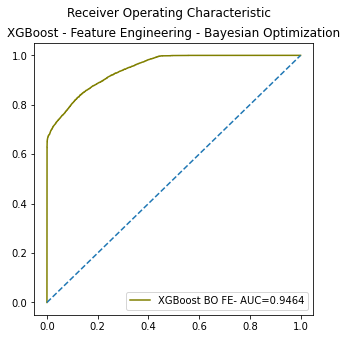

In [106]:
y_pred_proba = clf_xgb_BO_FE.predict_proba(X_test)[::,1]
fpr_xgb_BO_FE, tpr_xgb_BO_FE, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb_BO_FE = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('XGBoost - Feature Engineering - Bayesian Optimization')
plt.plot(fpr_xgb_BO_FE,tpr_xgb_BO_FE,color="olive",label="XGBoost BO FE- AUC=%.4f" % auc_xgb_BO_FE)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### LightGBM FE default

In [107]:
# build the lightgbm model
clf_lgbm_FE = lgb.LGBMClassifier()
clf_lgbm_FE.fit(X_train, y_train)

# predict the results
y_pred=clf_lgbm_FE.predict(X_test)

In [108]:
y_pred_train = clf_lgbm_FE.predict(X_train)

In [109]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135640
           1       0.97      0.65      0.78      5171

    accuracy                           0.99    140811
   macro avg       0.98      0.82      0.89    140811
weighted avg       0.99      0.99      0.99    140811



In [110]:
confusion_matrix(y_test, y_pred)

array([[135547,     93],
       [  1817,   3354]], dtype=int64)

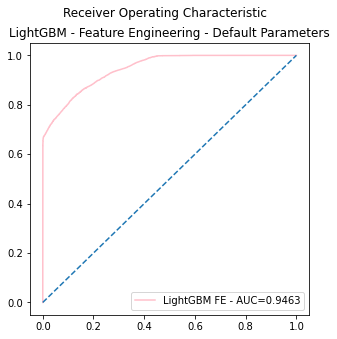

In [111]:
y_pred_proba = clf_lgbm_FE.predict_proba(X_test)[::,1]
fpr_lgbm_FE, tpr_lgbm_FE, _ = roc_curve(y_test,  y_pred_proba)
auc_lgbm_FE = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('LightGBM - Feature Engineering - Default Parameters')
plt.plot(fpr_lgbm_FE,tpr_lgbm_FE,color="pink",label="LightGBM FE - AUC=%.4f" % auc_lgbm_FE)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### LightGBM FE BO

In [112]:
clf_lgbm_BO_FE = lgb.LGBMClassifier(boosting_type='gbdt', metric='auc', objective='binary', 
                                    n_jobs=1, verbose=-1, random_state=0)

In [113]:
opt = BayesSearchCV(estimator=clf_lgbm_BO_FE,                                    
                    search_spaces=search_spaces,                      
                    scoring=roc_auc,                                  
                    cv=skf,                                           
                    n_iter=250,                                       # 3000 - max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [114]:
##### overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
##### time_limit_control = DeadlineStopper(total_time=60 * 25)     # We impose a time limit (45 minutes)
##### best_params = report_perf(opt, X_train, y_train,'LightGBM', callbacks=[overdone_control, time_limit_control])

In [115]:
# build the lightgbm model
clf_lgbm_BO_FE = lgb.LGBMClassifier(colsample_bytree=0.9716227061653782,
             learning_rate=0.01983159193222399,
             max_bin=100,
             max_depth=100,
             min_child_samples=1,
             min_child_weight=10,
             n_estimators=800,
             num_leaves=285,
             reg_alpha=100,
             reg_lambda=7.552303715661615e-06,
             scale_pos_weight=332.93,
             subsample=1,
             subsample_freq=0)
clf_lgbm_BO_FE.fit(X_train, y_train)

# predict the results
y_pred=clf_lgbm_BO_FE.predict(X_test)

In [116]:
y_pred_train = clf_lgbm_BO_FE.predict(X_train)

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    135640
           1       0.12      0.91      0.21      5171

    accuracy                           0.75    140811
   macro avg       0.56      0.82      0.53    140811
weighted avg       0.96      0.75      0.83    140811



In [118]:
confusion_matrix(y_test, y_pred)

array([[100424,  35216],
       [   487,   4684]], dtype=int64)

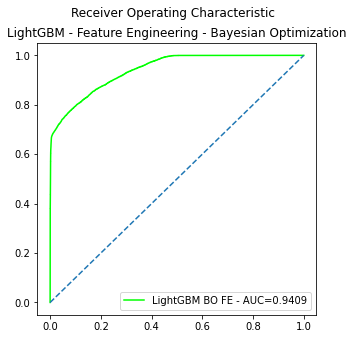

In [119]:
y_pred_proba = clf_lgbm_BO_FE.predict_proba(X_test)[::,1]
fpr_lgbm_BO_FE, tpr_lgbm_BO_FE, _ = roc_curve(y_test,  y_pred_proba)
auc_lgbm_BO_FE = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.suptitle('Receiver Operating Characteristic')
plt.title('LightGBM - Feature Engineering - Bayesian Optimization')
plt.plot(fpr_lgbm_BO_FE,tpr_lgbm_BO_FE,color="lime",label="LightGBM BO FE - AUC=%.4f" % auc_lgbm_BO_FE)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ROC Curve y AUC - LightGBM y XGBoost - Default/BO/FE/FEBO

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

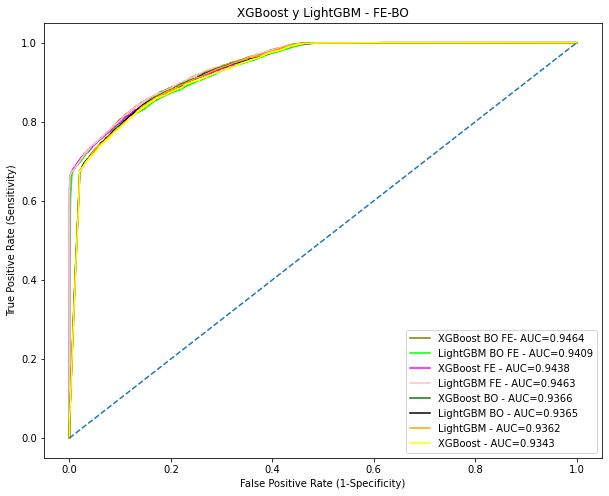

In [120]:
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.title('XGBoost y LightGBM - FE-BO')
plt.plot(fpr_xgb_BO_FE,tpr_xgb_BO_FE,color="olive",label="XGBoost BO FE- AUC=%.4f" % auc_xgb_BO_FE)
plt.plot(fpr_lgbm_BO_FE,tpr_lgbm_BO_FE,color="lime",label="LightGBM BO FE - AUC=%.4f" % auc_lgbm_BO_FE)
plt.plot(fpr_xgb_FE,tpr_xgb_FE,color="magenta",label="XGBoost FE - AUC=%.4f" % auc_xgb_FE)
plt.plot(fpr_lgbm_FE,tpr_lgbm_FE,color="pink",label="LightGBM FE - AUC=%.4f" % auc_lgbm_FE)
plt.plot(fpr_xgb_BO,tpr_xgb_BO,color="green",label="XGBoost BO - AUC=%.4f" % auc_xgb_BO)
plt.plot(fpr_lgbm_BO,tpr_lgbm_BO,color="black",label="LightGBM BO - AUC=%.4f" % auc_lgbm_BO)
plt.plot(fpr_lgbm,tpr_lgbm,color="orange",label="LightGBM - AUC=%.4f" % auc_lgbm)
plt.plot(fpr_xgb,tpr_xgb,color="yellow",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.savefig('plt_ROC_Curve_Final.jpg')
plt.show()

In [137]:
data= {
"XGB_BO_FE":auc_xgb_BO_FE,
"LGBM_BO_FE":auc_lgbm_BO_FE,
"XGB_FE":auc_xgb_FE,
"LGBM_FE":auc_lgbm_FE,
"XGB_BO":auc_xgb_BO,
"LGBM_BO":auc_lgbm_BO,
"LGBM":auc_lgbm,
"XGB":auc_xgb
}

In [138]:
data

{'XGB_BO_FE': 0.946386923169793,
 'LGBM_BO_FE': 0.94632128321405,
 'XGB_FE': 0.9437938900684756,
 'LGBM_FE': 0.9409328978997895,
 'XGB_BO': 0.9366179884459876,
 'LGBM_BO': 0.9365301427253973,
 'LGBM': 0.9362335649538368,
 'XGB': 0.9342897293283364}

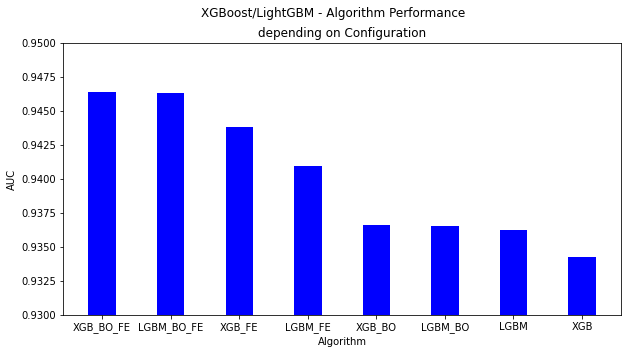

In [141]:
# creating the dataset
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue', width = 0.4)
plt.ylim(0.93, 0.95)
plt.xlabel("Algorithm")
plt.ylabel("AUC")
plt.suptitle("XGBoost/LightGBM - Algorithm Performance")
plt.title("depending on Configuration")
plt.show()